# First look at the data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

%matplotlib inline

In [2]:
comments = pd.read_csv("../toxic_comment_data/train.csv")

**Here we examine the training data (labeled with whether something is an insult or not). Some charming people.**

In [3]:
print("Rows: " + str(comments.shape[0]))
print("Columns: " + str(comments.shape[1]))
print("Number of insulting comments: " + str(len(comments[comments['Insult'] == 1])))
print("Number of non-insulting comments: " + str(len(comments[comments['Insult'] == 0])))
print("Number of comments missing dates: " + str(comments.isnull().sum().Date))

comments[0:10]

Rows: 3947
Columns: 3
Number of insulting comments: 1049
Number of non-insulting comments: 2898
Number of comments missing dates: 718


,Insult,Date,Comment
0,1,20120618192155Z,"""You fuck your dad."""
1,0,20120528192215Z,"""i really don't understand your point.\xa0 It ..."
2,0,NaN,"""A\\xc2\\xa0majority of Canadians can and has ..."
3,0,NaN,"""listen if you dont wanna get married to a man..."
4,0,20120619094753Z,"""C\xe1c b\u1ea1n xu\u1ed1ng \u0111\u01b0\u1edd..."
5,0,20120620171226Z,"""@SDL OK, but I would hope they'd sign him to ..."
6,0,20120503012628Z,"""Yeah and where are you now?"""
7,1,NaN,"""shut the fuck up. you and the rest of your fa..."
8,1,20120502173553Z,"""Either you are fake or extremely stupid...may..."
9,1,20120620160512Z,"""That you are an idiot who understands neither..."


**The comments are all unicode escaped, so inplace of special symbols there is some \escapeCode. It can be decoded if necessary as shown below.**

**Most of the data is english, but not all of it, not really a big deal though I suppose.**

In [4]:
sample_comment = comments.iloc[4].Comment
print(sample_comment)

"C\xe1c b\u1ea1n xu\u1ed1ng \u0111\u01b0\u1eddng bi\u1ec3u t\xecnh 2011 c\xf3 \xf4n ho\xe0 kh\xf4ng ? \nC\xe1c ng\u01b0 d\xe2n ng\u1ed3i cu\xed \u0111\u1ea7u chi\u1ee5 nh\u1ee5c c\xf3 \xf4n ho\xe0 kh\xf4ng ?\nC\xe1c n\xf4ng d\xe2n gi\u1eef \u0111\u1ea5t \u1edf V\u0103n Giang, C\u1ea7n Th\u01a1 c\xf3 \xf4n ho\xe0 kh\xf4ng ?\n.................\nR\u1ed1t cu\u1ed9c \u0111\u01b0\u1ee3c g\xec\xa0 th\xec ch\xfang ta \u0111\xe3 bi\u1ebft !\nAi c\u0169ng y\xeau chu\u1ed9ng ho\xe0 b\xecnh, nh\u01b0ng \u0111\xf4i khi ho\xe0 b\xecnh ch\u1ec9 th\u1eadt s\u1ef1 \u0111\u1ebfn sau chi\u1ebfn tranh m\xe0 th\xf4i.\nKh\xf4ng c\xf2n con \u0111\u01b0\u1eddng n\xe0o ch\u1ecdn kh\xe1c \u0111\xe2u, \u0111\u1eebng m\u01a1 th\xeam n\u01b0\xe3."


In [5]:
decoded_comment = bytes(sample_comment, 'ascii').decode('unicode-escape')
print(decoded_comment)

"Các bạn xuống đường biểu tình 2011 có ôn hoà không ? 
Các ngư dân ngồi cuí đầu chiụ nhục có ôn hoà không ?
Các nông dân giữ đất ở Văn Giang, Cần Thơ có ôn hoà không ?
.................
Rốt cuộc được gì  thì chúng ta đã biết !
Ai cũng yêu chuộng hoà bình, nhưng đôi khi hoà bình chỉ thật sự đến sau chiến tranh mà thôi.
Không còn con đường nào chọn khác đâu, đừng mơ thêm nưã."


**Lets add a column to the dataset that contains the length of every comment, we can use the built in method .str.len() from pandas, as opposed to doing something like len(x) where x is the comment string. This will deal with NaN cases automatically, were a string to not to be present for whatever reason. This also prevents a potential TypeError with standard len. **

_Note: this length measurement obviously includes all the unicode escape characters, so I also created a new column "True Length" which represents the length you would expect if it was printed normally. This utilizes the function below._

Lets add a column to the dataset that contains the length of every comment. Using the .str.len() function from pandas will deal with NaN automatically.

_Note: This length measurement obviously includes all the unicode escape characters, so we also created a new column "True Length" which represents the length you would expect if it was printed normally._

In [6]:
def true_length(input):
    if type(input) is str:
        return len(bytes(input, 'ascii').decode('unicode-escape'))
    else: 
        return -1 #arbitrary, should not ever happen with this dataset

In [7]:
comments['Raw_Length']  = comments['Comment'].str.len()
comments['True_Length'] = comments['Comment'].apply(lambda x: true_length(x))

comments[55:59]

,Insult,Date,Comment,Raw_Length,True_Length
55,1,20120502173058Z,"""You're a moron, truth is beyond your reach""",44,44
56,0,20120529022638Z,"""You seem wistful.""",19,19
57,0,20120529141937Z,"""Damn, speedy recovery, Paul...raining prayers...",60,60
58,0,20120528151453Z,"""The laughs you two heard were triggered by me...",100,100


**Just wanted to try normalizing the length...**

In [8]:
col_max = comments['True_Length'].max()
col_min = comments['True_Length'].min()
comments['Norm_True_Length'] = comments['True_Length'].apply(lambda x: (x-col_min)/(col_max-col_min))
comments[75:78]

,Insult,Date,Comment,Raw_Length,True_Length,Norm_True_Length
75,0,20120528200101Z,"""Are you in France?""",20,20,0.000791
76,0,20120620001100Z,"""I'll take that temp...I really hate the heat""",46,46,0.002261
77,0,20120620070034Z,"""Alexis Bledel can act. Wait. Can she? I have ...",198,196,0.010739


**Sanity check to verify that the min value has norm length 0, and max value has norm length 1:**

In [9]:
maxv = comments.iloc[comments['True_Length'].idxmax()].Norm_True_Length
minv = comments.iloc[comments['True_Length'].idxmin()].Norm_True_Length
print("Minimum length:",comments['True_Length'].min(),"      normalized:",minv)
print("Maximum length:",comments['True_Length'].max(),"  normalized:",maxv)

Minimum length: 6       normalized: 0.0
Maximum length: 17698   normalized: 1.0


# Comments

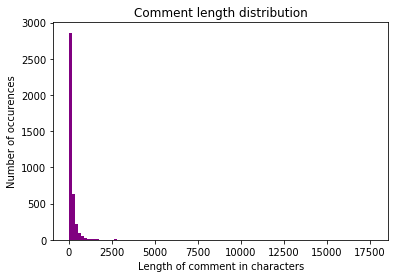

In [10]:
plt.hist(comments.True_Length,color="purple",bins=100)
plt.xlabel('Length of comment in characters')
plt.ylabel('Number of occurences')
plt.title('Comment length distribution');

Clearly, a vast majority of the comments are less than 2500 characters in length...

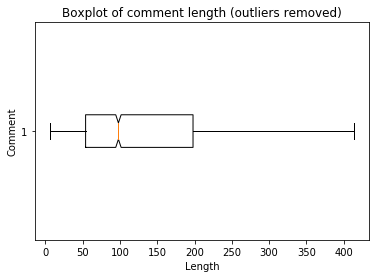

In [11]:
plt.boxplot(comments[comments['True_Length'] < 5000].True_Length,1,'',0)
plt.title("Boxplot of comment length (outliers removed)")
plt.ylabel("Comment")
plt.xlabel("Length");

In [12]:
print("Longest comment:  " + str(comments['True_Length'].max()) + " characters")
print("Shortest comment: " + str(comments['True_Length'].min()) + " characters")
print("Average:          " + str(round(comments.True_Length.mean())) + " characters")
print("Median:          " + str(round(comments.True_Length.median())) + " characters")

Longest comment:  17698 characters
Shortest comment: 6 characters
Average:          190 characters
Median:          98 characters


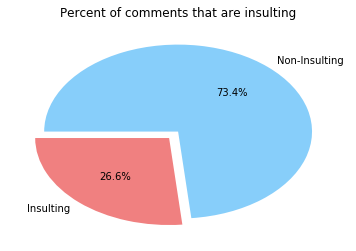

In [13]:
ins = len(comments[comments['Insult'] == 1]) # number of insulting commments
non = len(comments[comments['Insult'] == 0]) # number of non-insulting comments
percents = [ins,non]

labels = 'Insulting', 'Non-Insulting'
colors = ['lightcoral', 'lightskyblue']
explode = (0.1, 0)  # explode 1st slice

plt.title("Percent of comments that are insulting")
plt.pie(percents, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', startangle=180);

# Common techniques for dealing with textual data

Text needs special preparation before using it for predictive modeling. Usually have to convert text to numbers in some way. The most common way of working with textual data is to utilize the "Bag of Words" model. 

- **Term frequency:** how many times a term appears in the texts
- **TF-IDF:** normalizes standard term frequency by taking into account how often words appear in general
- **N-grams:** a way of separating the words to preserve spatial infomration

Example of a standard (unigram) bag of words:

In [14]:
vectorizer = CountVectorizer()
analyze = vectorizer.build_analyzer()

text = comments.iloc[9].Comment # load comment number 9
print(text,"\n")
print(analyze(text)) 

"That you are an idiot who understands neither taxation nor women's health." 

['that', 'you', 'are', 'an', 'idiot', 'who', 'understands', 'neither', 'taxation', 'nor', 'women', 'health']


Example of bigrams: 

In [15]:
bigram_vectorizer = CountVectorizer(ngram_range=(1, 2))
analyze = bigram_vectorizer.build_analyzer()

text = comments.iloc[9].Comment # load comment number 9
print(text,"\n")
print(analyze(text)) 

"That you are an idiot who understands neither taxation nor women's health." 

['that', 'you', 'are', 'an', 'idiot', 'who', 'understands', 'neither', 'taxation', 'nor', 'women', 'health', 'that you', 'you are', 'are an', 'an idiot', 'idiot who', 'who understands', 'understands neither', 'neither taxation', 'taxation nor', 'nor women', 'women health']


Example counting word occurences: 

In [16]:
vectorizer = CountVectorizer()

corpus = comments.Comment[8:10].as_matrix() # load comments 8 to 10
corpus = np.append(corpus,"you you you you you you you") # add a bunch of 'yous' to make counts obvious

print("Original documents:\n",corpus,"\n")
counts = vectorizer.fit_transform(corpus).toarray()
print("Dictionary of words:\n",vectorizer.get_feature_names(),"\n")
print("Word frequency from dictionary, per document:\n",counts)


Original documents:
 ['"Either you are fake or extremely stupid...maybe both..."'
 '"That you are an idiot who understands neither taxation nor women\'s health."'
 'you you you you you you you'] 

Dictionary of words:
 ['an', 'are', 'both', 'either', 'extremely', 'fake', 'health', 'idiot', 'maybe', 'neither', 'nor', 'or', 'stupid', 'taxation', 'that', 'understands', 'who', 'women', 'you'] 

Word frequency from dictionary, per document:
 [[0 1 1 1 1 1 0 0 1 0 0 1 1 0 0 0 0 0 1]
 [1 1 0 0 0 0 1 1 0 1 1 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 7]]
